**PA4**: Decision Trees

**Team 5**:  Mohammad Parsazadeh, Hadis Ebrahimi, Andrii Shcherbukha

**Dataset**: New York City Airbnb Open Data (AB_NYC_2019.csv)


## Loading data

In [ ]:
import numpy as np
import pandas as pd
import plotly.express as px

from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

from google.colab import drive

drive.mount('/content/drive')


files_dir = "/content/drive/MyDrive/Colab Notebooks/datasets/"
filename = files_dir + "AB_NYC_2019.csv"

df = pd.read_csv(filename) 


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Cleaning Data

In [ ]:
# before moving forward there are a few 
# features that could use better names
df.rename(columns=
            {"id": "listing_id", 
             "name": "listing_title",
             "host_name":"host_first_name",
             "neighbourhood_group":"nyc_borough",
             "room_type": "property_type",
             "last_review": "last_review_date"
            },
          inplace=True)

df

,listing_id,listing_title,host_id,host_first_name,nyc_borough,neighbourhood,latitude,longitude,property_type,price,minimum_nights,number_of_reviews,last_review_date,reviews_per_month,calculated_host_listings_count,availability_365
0,2539,Clean & quiet apt home by the park,2787,John,Brooklyn,Kensington,40.64749,-73.97237,Private room,149,1,9,2018-10-19,0.21,6,365
1,2595,Skylit Midtown Castle,2845,Jennifer,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,1,45,2019-05-21,0.38,2,355
2,3647,THE VILLAGE OF HARLEM....NEW YORK !,4632,Elisabeth,Manhattan,Harlem,40.80902,-73.94190,Private room,150,3,0,NaN,NaN,1,365
3,3831,Cozy Entire Floor of Brownstone,4869,LisaRoxanne,Brooklyn,Clinton Hill,40.68514,-73.95976,Entire home/apt,89,1,270,2019-07-05,4.64,1,194
4,5022,Entire Apt: Spacious Studio/Loft by central park,7192,Laura,Manhattan,East Harlem,40.79851,-73.94399,Entire home/apt,80,10,9,2018-11-19,0.10,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48890,36484665,Charming one bedroom - newly renovated rowhouse,8232441,Sabrina,Brooklyn,Bedford-Stuyvesant,40.67853,-73.94995,Private room,70,2,0,NaN,NaN,2,9
48891,36485057,Affordable room in Bushwick/East Williamsburg,6570630,Marisol,Brooklyn,Bushwick,40.70184,-73.93317,Private room,40,4,0,NaN,NaN,2,36
48892,36485431,Sunny Studio at Historical Neighborhood,23492952,Ilgar & Aysel,Manhattan,Harlem,40.81475,-73.94867,Entire home/apt,115,10,0,NaN,NaN,1,27
48893,36485609,43rd St. Time Square-cozy single bed,30985759,Taz,Manhattan,Hell's Kitchen,40.75751,-73.99112,Shared room,55,1,0,NaN,NaN,6,2


Now let's remove duplicates and rows that make little sense


In [ ]:
# checking for duplicates
print(df.duplicated().any())
print(df.duplicated(subset=['listing_id']).any())

False
False


Now let's check for NAs

In [ ]:
display(df.isnull().sum())
display(df.query('reviews_per_month != reviews_per_month'))

# we don't care about titles and first names
# 10,052 listings had no reviews which 
# resulted in NaN values in  
# reviews_per_month columns
# we just need to fill those out with zeros

df_clean = df.fillna({
    'reviews_per_month':0
    })

# we will deal with last review date later

listing_id                            0
listing_title                        16
host_id                               0
host_first_name                      21
nyc_borough                           0
neighbourhood                         0
latitude                              0
longitude                             0
property_type                         0
price                                 0
minimum_nights                        0
number_of_reviews                     0
last_review_date                  10052
reviews_per_month                 10052
calculated_host_listings_count        0
availability_365                      0
dtype: int64

,listing_id,listing_title,host_id,host_first_name,nyc_borough,neighbourhood,latitude,longitude,property_type,price,minimum_nights,number_of_reviews,last_review_date,reviews_per_month,calculated_host_listings_count,availability_365
2,3647,THE VILLAGE OF HARLEM....NEW YORK !,4632,Elisabeth,Manhattan,Harlem,40.80902,-73.94190,Private room,150,3,0,NaN,NaN,1,365
19,7750,Huge 2 BR Upper East Cental Park,17985,Sing,Manhattan,East Harlem,40.79685,-73.94872,Entire home/apt,190,7,0,NaN,NaN,2,249
26,8700,Magnifique Suite au N de Manhattan - vue Cloitres,26394,Claude & Sophie,Manhattan,Inwood,40.86754,-73.92639,Private room,80,4,0,NaN,NaN,1,0
36,11452,Clean and Quiet in Brooklyn,7355,Vt,Brooklyn,Bedford-Stuyvesant,40.68876,-73.94312,Private room,35,60,0,NaN,NaN,1,365
38,11943,Country space in the city,45445,Harriet,Brooklyn,Flatbush,40.63702,-73.96327,Private room,150,1,0,NaN,NaN,1,365
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48890,36484665,Charming one bedroom - newly renovated rowhouse,8232441,Sabrina,Brooklyn,Bedford-Stuyvesant,40.67853,-73.94995,Private room,70,2,0,NaN,NaN,2,9
48891,36485057,Affordable room in Bushwick/East Williamsburg,6570630,Marisol,Brooklyn,Bushwick,40.70184,-73.93317,Private room,40,4,0,NaN,NaN,2,36
48892,36485431,Sunny Studio at Historical Neighborhood,23492952,Ilgar & Aysel,Manhattan,Harlem,40.81475,-73.94867,Entire home/apt,115,10,0,NaN,NaN,1,27
48893,36485609,43rd St. Time Square-cozy single bed,30985759,Taz,Manhattan,Hell's Kitchen,40.75751,-73.99112,Shared room,55,1,0,NaN,NaN,6,2


In [ ]:
df_clean.describe()

,listing_id,host_id,latitude,longitude,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365
count,4.889500e+04,4.889500e+04,48895.000000,48895.000000,48895.000000,48895.000000,48895.000000,48895.000000,48895.000000,48895.000000
mean,1.901714e+07,6.762001e+07,40.728949,-73.952170,152.720687,7.029962,23.274466,1.090910,7.143982,112.781327
std,1.098311e+07,7.861097e+07,0.054530,0.046157,240.154170,20.510550,44.550582,1.597283,32.952519,131.622289
min,2.539000e+03,2.438000e+03,40.499790,-74.244420,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000
25%,9.471945e+06,7.822033e+06,40.690100,-73.983070,69.000000,1.000000,1.000000,0.040000,1.000000,0.000000
50%,1.967728e+07,3.079382e+07,40.723070,-73.955680,106.000000,3.000000,5.000000,0.370000,1.000000,45.000000
75%,2.915218e+07,1.074344e+08,40.763115,-73.936275,175.000000,5.000000,24.000000,1.580000,2.000000,227.000000
max,3.648724e+07,2.743213e+08,40.913060,-73.712990,10000.000000,1250.000000,629.000000,58.500000,327.000000,365.000000


We probably want to look at rows where:
- price = 0
- long term renting (minimun_nights > 30)
- reviews_per_month > 30
- availability_365 = 0

In [ ]:
display(df_clean.query('price == 0'))

# we got 11 rows
# 0 price makes no sense and since 
# we will be trying to predict the price
# we should probably delete those

df_clean = df_clean.query('price > 0')


,listing_id,listing_title,host_id,host_first_name,nyc_borough,neighbourhood,latitude,longitude,property_type,price,minimum_nights,number_of_reviews,last_review_date,reviews_per_month,calculated_host_listings_count,availability_365
23161,18750597,"Huge Brooklyn Brownstone Living, Close to it all.",8993084,Kimberly,Brooklyn,Bedford-Stuyvesant,40.69023,-73.95428,Private room,0,4,1,2018-01-06,0.05,4,28
25433,20333471,★Hostel Style Room | Ideal Traveling Buddies★,131697576,Anisha,Bronx,East Morrisania,40.83296,-73.88668,Private room,0,2,55,2019-06-24,2.56,4,127
25634,20523843,"MARTIAL LOFT 3: REDEMPTION (upstairs, 2nd room)",15787004,Martial Loft,Brooklyn,Bushwick,40.69467,-73.92433,Private room,0,2,16,2019-05-18,0.71,5,0
25753,20608117,"Sunny, Quiet Room in Greenpoint",1641537,Lauren,Brooklyn,Greenpoint,40.72462,-73.94072,Private room,0,2,12,2017-10-27,0.53,2,0
25778,20624541,Modern apartment in the heart of Williamsburg,10132166,Aymeric,Brooklyn,Williamsburg,40.70838,-73.94645,Entire home/apt,0,5,3,2018-01-02,0.15,1,73
25794,20639628,Spacious comfortable master bedroom with nice ...,86327101,Adeyemi,Brooklyn,Bedford-Stuyvesant,40.68173,-73.91342,Private room,0,1,93,2019-06-15,4.28,6,176
25795,20639792,Contemporary bedroom in brownstone with nice view,86327101,Adeyemi,Brooklyn,Bedford-Stuyvesant,40.68279,-73.91170,Private room,0,1,95,2019-06-21,4.37,6,232
25796,20639914,Cozy yet spacious private brownstone bedroom,86327101,Adeyemi,Brooklyn,Bedford-Stuyvesant,40.68258,-73.91284,Private room,0,1,95,2019-06-23,4.35,6,222
26259,20933849,the best you can find,13709292,Qiuchi,Manhattan,Murray Hill,40.75091,-73.97597,Entire home/apt,0,3,0,NaN,0.00,1,0
26841,21291569,Coliving in Brooklyn! Modern design / Shared room,101970559,Sergii,Brooklyn,Bushwick,40.69211,-73.90670,Shared room,0,30,2,2019-06-22,0.11,6,333


In [ ]:
display(df_clean.query('minimum_nights > 11'))

# 747 rows 
# I would either remove those
# or add a new binary feature "long-term renting"
# since conditions for long-term renting could 
# be different and this could confuse our model
# 11 btw is IRQ upper fence
# we'll do it in the next section





,listing_id,listing_title,host_id,host_first_name,nyc_borough,neighbourhood,latitude,longitude,property_type,price,minimum_nights,number_of_reviews,last_review_date,reviews_per_month,calculated_host_listings_count,availability_365
6,5121,BlissArtsSpace!,7356,Garon,Brooklyn,Bedford-Stuyvesant,40.68688,-73.95596,Private room,60,45,49,2017-10-05,0.40,1,0
14,6090,West Village Nest - Superhost,11975,Alina,Manhattan,West Village,40.73530,-74.00525,Entire home/apt,120,90,27,2018-10-31,0.22,1,0
29,9657,Modern 1 BR / NYC / EAST VILLAGE,21904,Dana,Manhattan,East Village,40.72920,-73.98542,Entire home/apt,180,14,29,2019-04-19,0.24,1,67
36,11452,Clean and Quiet in Brooklyn,7355,Vt,Brooklyn,Bedford-Stuyvesant,40.68876,-73.94312,Private room,35,60,0,NaN,0.00,1,365
45,12627,Entire apartment in central Brooklyn neighborh...,49670,Rana,Brooklyn,Prospect-Lefferts Gardens,40.65944,-73.96238,Entire home/apt,150,29,11,2019-06-05,0.49,1,95
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48810,36445121,UWS Spacious Master Bedroom Sublet,274014453,Dagmara,Manhattan,Upper West Side,40.79952,-73.96003,Private room,75,30,0,NaN,0.00,1,90
48843,36453642,"☆ HUGE, SUNLIT Room - 3 min walk from Train !",53966115,Nora,Brooklyn,Bedford-Stuyvesant,40.69635,-73.93743,Private room,45,29,0,NaN,0.00,2,341
48871,36475746,A LARGE ROOM - 1 MONTH MINIMUM - WASHER&DRYER,144008701,Ozzy Ciao,Manhattan,Harlem,40.82233,-73.94687,Private room,35,29,0,NaN,0.00,2,31
48879,36480292,Gorgeous 1.5 Bdr with a private yard- Williams...,540335,Lee,Brooklyn,Williamsburg,40.71728,-73.94394,Entire home/apt,120,20,0,NaN,0.00,1,22


In [ ]:
display(df_clean.query('reviews_per_month > 30'))

# even if we assume the property is booked for 1 night every night, 
# 58.5 reviews per months appears implausible 
# (as far as I know only guests can leave reviews, 
# so even if I ask my friends to join me in tanking the 
# rating of the property, airbnb won't allow that) 

df_clean = df_clean.query('reviews_per_month < 31')

,listing_id,listing_title,host_id,host_first_name,nyc_borough,neighbourhood,latitude,longitude,property_type,price,minimum_nights,number_of_reviews,last_review_date,reviews_per_month,calculated_host_listings_count,availability_365
42075,32678719,Enjoy great views of the City in our Deluxe Room!,244361589,Row NYC,Manhattan,Theater District,40.75918,-73.98801,Private room,100,1,156,2019-07-07,58.5,9,299


In [ ]:
display(df_clean.query('availability_365 == 0'))

# 12,686 rows that's about the quarter of our datapoints
# 0 availability could mean that the owner did not want to
# delist the property but it was temporarily unavailable
# e.g. due to renovations.
# I don't think availability has any effect on the price
# which we try to predict, so we can just remove that feature
# but keep the rows 

,listing_id,listing_title,host_id,host_first_name,nyc_borough,neighbourhood,latitude,longitude,property_type,price,minimum_nights,number_of_reviews,last_review_date,reviews_per_month,calculated_host_listings_count,availability_365
4,5022,Entire Apt: Spacious Studio/Loft by central park,7192,Laura,Manhattan,East Harlem,40.79851,-73.94399,Entire home/apt,80,10,9,2018-11-19,0.10,1,0
6,5121,BlissArtsSpace!,7356,Garon,Brooklyn,Bedford-Stuyvesant,40.68688,-73.95596,Private room,60,45,49,2017-10-05,0.40,1,0
8,5203,Cozy Clean Guest Room - Family Apt,7490,MaryEllen,Manhattan,Upper West Side,40.80178,-73.96723,Private room,79,2,118,2017-07-21,0.99,1,0
14,6090,West Village Nest - Superhost,11975,Alina,Manhattan,West Village,40.73530,-74.00525,Entire home/apt,120,90,27,2018-10-31,0.22,1,0
20,7801,Sweet and Spacious Brooklyn Loft,21207,Chaya,Brooklyn,Williamsburg,40.71842,-73.95718,Entire home/apt,299,3,9,2011-12-28,0.07,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48550,36313048,Sunny room with private entrance in shared home,16883913,Tiffany,Queens,Ridgewood,40.69919,-73.89902,Private room,45,1,0,NaN,0.00,1,0
48731,36410519,Sunlight charming apt. in the heart of Brooklyn,121384174,Luciana Paula,Brooklyn,Park Slope,40.66716,-73.98101,Entire home/apt,111,8,0,NaN,0.00,1,0
48756,36419441,Murray Hill Masterpiece,273824202,David,Manhattan,Murray Hill,40.74404,-73.97239,Entire home/apt,129,2,0,NaN,0.00,1,0
48760,36420725,"Sunnyside, Queens 15 Mins to Midtown Clean & C...",19990280,Brandon,Queens,Sunnyside,40.74719,-73.91919,Private room,46,1,0,NaN,0.00,1,0


So let's remove columns we won't need

In [ ]:
df_clean.drop([
        "listing_id", # listing id does not give us any valuable information
        "listing_title", # listing title could potentially be analyzed for key words, but not in this PA
        "host_id", # host id and host name do not give us any valuable information
        "host_first_name",
        #"latitude", # for location, we're going to use boroughs and neighbourhoods 
        #"longitude",# so lat and long can go
        'availability_365'], # explained above
        axis=1, 
        inplace=True
        )

display(df_clean)
display(df_clean.shape)

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4913: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,nyc_borough,neighbourhood,latitude,longitude,property_type,price,minimum_nights,number_of_reviews,last_review_date,reviews_per_month,calculated_host_listings_count
0,Brooklyn,Kensington,40.64749,-73.97237,Private room,149,1,9,2018-10-19,0.21,6
1,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,1,45,2019-05-21,0.38,2
2,Manhattan,Harlem,40.80902,-73.94190,Private room,150,3,0,NaN,0.00,1
3,Brooklyn,Clinton Hill,40.68514,-73.95976,Entire home/apt,89,1,270,2019-07-05,4.64,1
4,Manhattan,East Harlem,40.79851,-73.94399,Entire home/apt,80,10,9,2018-11-19,0.10,1
...,...,...,...,...,...,...,...,...,...,...,...
48890,Brooklyn,Bedford-Stuyvesant,40.67853,-73.94995,Private room,70,2,0,NaN,0.00,2
48891,Brooklyn,Bushwick,40.70184,-73.93317,Private room,40,4,0,NaN,0.00,2
48892,Manhattan,Harlem,40.81475,-73.94867,Entire home/apt,115,10,0,NaN,0.00,1
48893,Manhattan,Hell's Kitchen,40.75751,-73.99112,Shared room,55,1,0,NaN,0.00,6


(48883, 11)

## Feature Engineering

In [ ]:
# adding long term rent feature
df_clean['long_term_rent'] = (df_clean['minimum_nights'] > 11).astype(int)

# adding months on market column
# df_clean['months_on_market'] = df_clean['number_of_reviews'] / df_clean['reviews_per_month']


### One-hot encoding

In [ ]:
# property type
display(df_clean.property_type.unique())

# since these are going to be column names
# we need to lowercase them and remove spaces
df_clean['property_type'] = (df_clean['property_type']
                                  .str.lower()
                                  .replace(' ', '_', regex=True)
                            )

df_clean = pd.get_dummies(df_clean, prefix=['type'], columns=['property_type'])
display(df_clean)

array(['Private room', 'Entire home/apt', 'Shared room'], dtype=object)

,nyc_borough,neighbourhood,latitude,longitude,price,minimum_nights,number_of_reviews,last_review_date,reviews_per_month,calculated_host_listings_count,long_term_rent,type_entire_home/apt,type_private_room,type_shared_room
0,Brooklyn,Kensington,40.64749,-73.97237,149,1,9,2018-10-19,0.21,6,0,0,1,0
1,Manhattan,Midtown,40.75362,-73.98377,225,1,45,2019-05-21,0.38,2,0,1,0,0
2,Manhattan,Harlem,40.80902,-73.94190,150,3,0,NaN,0.00,1,0,0,1,0
3,Brooklyn,Clinton Hill,40.68514,-73.95976,89,1,270,2019-07-05,4.64,1,0,1,0,0
4,Manhattan,East Harlem,40.79851,-73.94399,80,10,9,2018-11-19,0.10,1,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48890,Brooklyn,Bedford-Stuyvesant,40.67853,-73.94995,70,2,0,NaN,0.00,2,0,0,1,0
48891,Brooklyn,Bushwick,40.70184,-73.93317,40,4,0,NaN,0.00,2,0,0,1,0
48892,Manhattan,Harlem,40.81475,-73.94867,115,10,0,NaN,0.00,1,0,1,0,0
48893,Manhattan,Hell's Kitchen,40.75751,-73.99112,55,1,0,NaN,0.00,6,0,0,0,1


In [ ]:
# neighbourhoods


display(df_clean.nyc_borough.unique())

# since these are going to be column names
# we need to lowercase them and remove spaces
df_clean['neighbourhood'] = (df_clean['neighbourhood']
                                  .str.lower()
                                  #.replace('.', ' ', regex=True)
                                  .replace(' ', '_', regex=True)
                            )

df_clean = pd.get_dummies(df_clean, prefix=['neighbourhood'], columns=['neighbourhood'])

display(df_clean)


array(['Brooklyn', 'Manhattan', 'Queens', 'Staten Island', 'Bronx'],
      dtype=object)

,nyc_borough,latitude,longitude,price,minimum_nights,number_of_reviews,last_review_date,reviews_per_month,calculated_host_listings_count,long_term_rent,...,neighbourhood_westerleigh,neighbourhood_whitestone,neighbourhood_williamsbridge,neighbourhood_williamsburg,neighbourhood_willowbrook,neighbourhood_windsor_terrace,neighbourhood_woodhaven,neighbourhood_woodlawn,neighbourhood_woodrow,neighbourhood_woodside
0,Brooklyn,40.64749,-73.97237,149,1,9,2018-10-19,0.21,6,0,...,0,0,0,0,0,0,0,0,0,0
1,Manhattan,40.75362,-73.98377,225,1,45,2019-05-21,0.38,2,0,...,0,0,0,0,0,0,0,0,0,0
2,Manhattan,40.80902,-73.94190,150,3,0,NaN,0.00,1,0,...,0,0,0,0,0,0,0,0,0,0
3,Brooklyn,40.68514,-73.95976,89,1,270,2019-07-05,4.64,1,0,...,0,0,0,0,0,0,0,0,0,0
4,Manhattan,40.79851,-73.94399,80,10,9,2018-11-19,0.10,1,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48890,Brooklyn,40.67853,-73.94995,70,2,0,NaN,0.00,2,0,...,0,0,0,0,0,0,0,0,0,0
48891,Brooklyn,40.70184,-73.93317,40,4,0,NaN,0.00,2,0,...,0,0,0,0,0,0,0,0,0,0
48892,Manhattan,40.81475,-73.94867,115,10,0,NaN,0.00,1,0,...,0,0,0,0,0,0,0,0,0,0
48893,Manhattan,40.75751,-73.99112,55,1,0,NaN,0.00,6,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:

# nyc_borough
# I'm not sure if having boroughs helps us
# since usually the more granular
# the data is the better and we have neoghbourhood
# will keep boroughs for now

display(df_clean.nyc_borough.unique())

# since these are going to be column names
# we need to lowercase them and remove spaces
df_clean['nyc_borough'] = (df_clean['nyc_borough']
                                      .str.lower()
                                      .replace(' ', '_', regex=True)
                          )

df_clean = pd.get_dummies(df_clean, prefix=['borough'], columns=['nyc_borough'])
display(df_clean)


array(['Brooklyn', 'Manhattan', 'Queens', 'Staten Island', 'Bronx'],
      dtype=object)

,latitude,longitude,price,minimum_nights,number_of_reviews,last_review_date,reviews_per_month,calculated_host_listings_count,long_term_rent,type_entire_home/apt,...,neighbourhood_windsor_terrace,neighbourhood_woodhaven,neighbourhood_woodlawn,neighbourhood_woodrow,neighbourhood_woodside,borough_bronx,borough_brooklyn,borough_manhattan,borough_queens,borough_staten_island
0,40.64749,-73.97237,149,1,9,2018-10-19,0.21,6,0,0,...,0,0,0,0,0,0,1,0,0,0
1,40.75362,-73.98377,225,1,45,2019-05-21,0.38,2,0,1,...,0,0,0,0,0,0,0,1,0,0
2,40.80902,-73.94190,150,3,0,NaN,0.00,1,0,0,...,0,0,0,0,0,0,0,1,0,0
3,40.68514,-73.95976,89,1,270,2019-07-05,4.64,1,0,1,...,0,0,0,0,0,0,1,0,0,0
4,40.79851,-73.94399,80,10,9,2018-11-19,0.10,1,0,1,...,0,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48890,40.67853,-73.94995,70,2,0,NaN,0.00,2,0,0,...,0,0,0,0,0,0,1,0,0,0
48891,40.70184,-73.93317,40,4,0,NaN,0.00,2,0,0,...,0,0,0,0,0,0,1,0,0,0
48892,40.81475,-73.94867,115,10,0,NaN,0.00,1,0,1,...,0,0,0,0,0,0,0,1,0,0
48893,40.75751,-73.99112,55,1,0,NaN,0.00,6,0,0,...,0,0,0,0,0,0,0,1,0,0


In [ ]:
# last_review_date

# originally I wanted to generate days since last review
# feature, but I would work poorly with NAs
# so perhaps we can add a few features indicating 
# whether last review was within last 6 and 12 months

# since we do not know when the dataset was created
# we will count from the latest available date 

df_clean['last_review_date'] = pd.to_datetime(df_clean['last_review_date']).dt.date

max_date = max(df_clean['last_review_date'])

df_clean['reviewed_in_last_6_months'] = \
  df_clean.last_review_date.between(max_date - pd.DateOffset(months=6), max_date).astype(int)

df_clean['reviewed_in_last_12_months'] = \
  df_clean.last_review_date.between(max_date - pd.DateOffset(months=6), max_date).astype(int)


print(df_clean[['last_review_date','reviewed_in_last_6_months', 'reviewed_in_last_12_months']])

# and now we can remove last_review_date
df_clean.drop(labels=['last_review_date'], inplace=True, axis=1)


      last_review_date  reviewed_in_last_6_months  reviewed_in_last_12_months
0           2018-10-19                          0                           0
1           2019-05-21                          1                           1
2                  NaT                          0                           0
3           2019-07-05                          1                           1
4           2018-11-19                          0                           0
...                ...                        ...                         ...
48890              NaN                          0                           0
48891              NaN                          0                           0
48892              NaN                          0                           0
48893              NaN                          0                           0
48894              NaN                          0                           0

[48883 rows x 3 columns]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: FutureWarning:

Comparison of NaT with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.

/usr/local/lib/python3.7/dist-packages/pandas/core/ops/array_ops.py:73: FutureWarning:

Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.



In [ ]:
# finally, we will create categories for our target label

df_clean['price'].describe()

#bins=[0, 50, 100, 200, 300, 10000]
#labels=['<50', '50-100', '100-200', '200-300', 'over 300']

#bins = [0, 69, 106, 175, 500, 10000] 
#labels = ["low", "fairly_low", "medium", "faily_high", "high"]

bins=[0, 50, 100, 200, 300, 400, 500, 600, 700, 800, 900, 1000, 10000]
labels=['<50', '50-100', '100-200', '200-300', '300-400', '400-500', '500-600', '600-700', '700-800', '800-900', '900-1000', 'over 1k']

df_clean['price_category'] = pd.cut(
    df_clean.price, 
    bins=bins,
    labels=labels
    )



# TOD0:
pd.qcut(df_clean['price'], q=8)

### Labeling

In [ ]:
label_name = "price_category"
label_name_num = 'price'

numerical_feature_names = [
    "minimum_nights",
    "number_of_reviews",
    "reviews_per_month",
    "calculated_host_listings_count"
    ]

non_numerical_feature_names = (
    df_clean[df_clean.columns.difference(
                                         numerical_feature_names 
                                         #+ ['nyc_borough']
                                         + ['neighbourhood']
                                         + [label_name]
                                         + [label_name_num]
                                         + ['latitude']
                                         + ['longitude']
                                         )].columns
    )

numerical_feature_names = [
    "minimum_nights",
    #"number_of_reviews",
    "reviews_per_month",
    "calculated_host_listings_count"
    ]

all_features = np.concatenate((numerical_feature_names, non_numerical_feature_names))


### 0. Splitting test and train data

In [ ]:
from sklearn import model_selection
X_train, X_test, y_train, y_test = model_selection.train_test_split(df_clean[all_features], df_clean[label_name], test_size=0.2, random_state=23)

### 0. Imbalanced data

In [ ]:
px.histogram(y_train)

Our data is quite imbalanced, so we will try to use a few techniques to handle that and see if it makes any difference.

In [ ]:
from imblearn.over_sampling import RandomOverSampler
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import NearMiss

oversample = SMOTE(sampling_strategy='all')

X_train_ovrsmpl, y_train_ovrsmpl = oversample.fit_resample(X_train, y_train)
px.histogram(y_train_ovrsmpl)


In [ ]:
from imblearn.under_sampling import RandomUnderSampler

oversample = RandomUnderSampler()

X_train_undrsmpl, y_train_undrsmpl = oversample.fit_resample(X_train, y_train)
px.histogram(y_train_undrsmpl)

## Exploring decision tree construction:
Vary the following hyperparameters to build your decision tree classifier and report the evaluation metrics for both your training and testing data.


### 1.Vary the criterion hyperparameter:



#### a. Create a DT using the criterion parameter “gini” and report the accuracy, precision, recall and F1score.
#### b.Createa DT using the criteri on parameter “entropy” and report the accuracy, pre:cision, recall and F1score.

In [ ]:
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report


for criterion in ['gini', 'entropy']:
  dtree = DecisionTreeClassifier(criterion=criterion)
  dtree.fit(X_train, y_train)
  y_hat = dtree.predict(X_test)
  accuracy = round(accuracy_score(y_test, y_hat), 2)
  precision = round(precision_score(y_test, y_hat, average='weighted', zero_division=0), 2)
  recall = round(recall_score(y_test, y_hat, average='weighted', zero_division=0), 2)
  f1 = round(f1_score(y_test, y_hat, average='weighted', zero_division=0), 2)

  print(f"{criterion} results: Accuracy: {accuracy}, Precision: {precision}, Recall: {recall}, f1: {f1}")
  

gini results: Accuracy: 0.48, Precision: 0.47, Recall: 0.48, f1: 0.48
entropy results: Accuracy: 0.48, Precision: 0.47, Recall: 0.48, f1: 0.48


NOTES:

According to [Theoretical comparison between the gini index and information gain criteria](https://www.unine.ch/files/live/sites/imi/files/shared/documents/papers/Gini_index_fulltext.pdf) it seems that Entropy might be a little slower to compute (because it makes use of the logarithm). Other than that, it only matters in tiny % of cases whether to use gini impurity or entropy.
In our case the difference in compute time is negligible and entropy index does have a slight advantage for almost all the buckets. 

On stack I found a comment that both metrics exist because they emerged in different disciplines of science.

### 2.Vary the splitter hyperparameter:


#### a.Createa DT using the splitter parameter “best” and report the accuracy precision, recall and F1score.
#### b.Createa DT using the splitter parameter “random” and report the accuracy, precision, recall and F1score.


In [ ]:
import time 
for splitter in ['best', 'random']:
  # usually, the decision tree chooses to split each 
  # node in the optimal point (based on gini or entropy). 
  # however, it would be faster, and possibly not much worse, 
  # to use a random split.
  
  t = time.time()
  
  dtree = DecisionTreeClassifier(splitter=splitter)
  dtree.fit(X_train, y_train)
  y_hat = dtree.predict(X_test)
  print(f"report for {splitter} splitter:")
  accuracy = round(accuracy_score(y_test, y_hat), 2)
  precision = round(precision_score(y_test, y_hat, average='weighted', zero_division=0), 2)
  recall = round(recall_score(y_test, y_hat, average='weighted', zero_division=0), 2)
  f1 = round(f1_score(y_test, y_hat, average='weighted', zero_division=0), 2)

  print(f"{splitter} splitter results: Accuracy: {accuracy}, Precision: {precision}, Recall: {recall}, f1: {f1}, run_time: {time.time() - t}")

report for best splitter:
best splitter results: Accuracy: 0.48, Precision: 0.47, Recall: 0.48, f1: 0.48, run_time: 1.0558621883392334
report for random splitter:
random splitter results: Accuracy: 0.49, Precision: 0.48, Recall: 0.49, f1: 0.48, run_time: 1.0086469650268555


NOTES:
The majority of our features are binary neighbourhood columns which have just one potential split point: 0.5, making random and best equal for all those features. 

### 3.Vary themin_samples_split hyperparameter:


#### a. Choose value 1 as yourmin_samples_split and report thea ccuracy,precision,recall and F1score.
#### b.Choose value 2 as your min_samples_split and report the accuracy,precision, recall and F1score.



In [ ]:
for samples_split in [1.0, 2, 300]:
  # minimum number of samples 
  # required to split an internal node
  # default is 2
  dtree = DecisionTreeClassifier(min_samples_split=samples_split)
  dtree.fit(X_train, y_train)
  y_hat = dtree.predict(X_test)
  print(f"report for min_samples_split={samples_split}:")

  print(classification_report(
          y_test, 
          y_hat,
          labels=np.array(labels)
        )
    )

report for min_samples_split=1.0:


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



              precision    recall  f1-score   support

         <50       0.00      0.00      0.00      1365
      50-100       0.54      0.75      0.63      3397
     100-200       0.53      0.79      0.63      3342
     200-300       0.00      0.00      0.00       993
     300-400       0.00      0.00      0.00       335
     400-500       0.00      0.00      0.00       133
     500-600       0.00      0.00      0.00        62
     600-700       0.00      0.00      0.00        40
     700-800       0.00      0.00      0.00        32
     800-900       0.00      0.00      0.00        10
    900-1000       0.00      0.00      0.00        16
     over 1k       0.00      0.00      0.00        52

    accuracy                           0.53      9777
   macro avg       0.09      0.13      0.11      9777
weighted avg       0.37      0.53      0.44      9777

report for min_samples_split=2:
              precision    recall  f1-score   support

         <50       0.50      0.41      0.45   

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



              precision    recall  f1-score   support

         <50       0.60      0.37      0.45      1365
      50-100       0.59      0.68      0.63      3397
     100-200       0.54      0.76      0.63      3342
     200-300       0.41      0.15      0.22       993
     300-400       0.08      0.00      0.01       335
     400-500       0.08      0.02      0.03       133
     500-600       0.00      0.00      0.00        62
     600-700       0.57      0.10      0.17        40
     700-800       0.00      0.00      0.00        32
     800-900       0.00      0.00      0.00        10
    900-1000       0.00      0.00      0.00        16
     over 1k       0.21      0.06      0.09        52

    accuracy                           0.56      9777
   macro avg       0.26      0.18      0.19      9777
weighted avg       0.52      0.56      0.52      9777



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



NOTES:This is interesting, the default setting has better performance in the underrepresented classes while 1 and 300 values beat the default in two major classes (50-100 and 100-200) at the expense of the underrepresented classes. That did not make sense to me until the documentation revealed that (0-1] paremeter range means in fact ceil(min_samples_split * n_samples) so that's number of samples in our case.<br><br>
We can also plot how accuracy depends on this parameter:

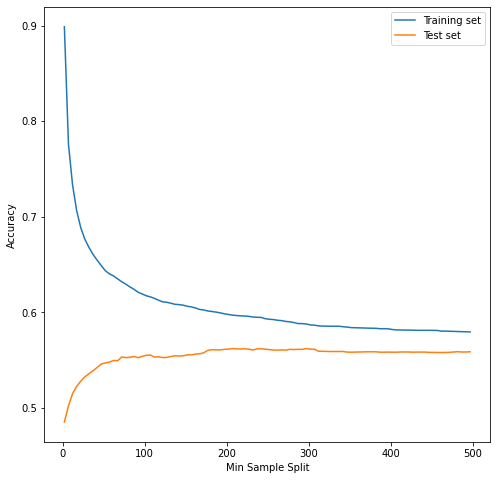

In [ ]:
import matplotlib.pyplot as plt
test_score = []
train_score = []
min_sample_split = np.arange(2, 500, 5)

for samples_split in min_sample_split:
  dtree = DecisionTreeClassifier(min_samples_split=samples_split)
  dtree.fit(X_train, y_train)
  train_score.append(dtree.score(X_train,y_train))
  test_score.append(dtree.score(X_test,y_test))
  
plt.figure(figsize = (8,8))   
plt.plot(min_sample_split,train_score)
plt.plot(min_sample_split, test_score)
plt.xlabel('Min Sample Split')
plt.ylabel('Accuracy')
plt.legend(['Training set','Test set'])

### 4.Vary themin_samples_leaf hyperparameter:


#### a. Choose value 1 as yourmin_samples_leaf and repor tthe accuracy, precision, recall and F1score.

#### b.Choose value 2 as your min_samples_leafandreporttheaccuracy, precision, recall and F1score.



In [ ]:
for samples_split in [1, 2]:
  # minimum number of samples 
  # required to be at a leaf node
  dtree = DecisionTreeClassifier(min_samples_leaf=samples_split)
  dtree.fit(X_train, y_train)
  y_hat = dtree.predict(X_test)
  print(f"report for min_samples_leaf={samples_split}:")
  print(classification_report(
          y_test, 
          y_hat,
          labels=np.array(labels)
        )
    )

report for min_samples_leaf=1:
              precision    recall  f1-score   support

         <50       0.50      0.41      0.45      1365
      50-100       0.55      0.59      0.57      3397
     100-200       0.52      0.55      0.53      3342
     200-300       0.27      0.26      0.26       993
     300-400       0.13      0.09      0.11       335
     400-500       0.05      0.04      0.04       133
     500-600       0.00      0.00      0.00        62
     600-700       0.18      0.12      0.15        40
     700-800       0.23      0.19      0.21        32
     800-900       0.00      0.00      0.00        10
    900-1000       0.00      0.00      0.00        16
     over 1k       0.17      0.13      0.15        52

    accuracy                           0.48      9777
   macro avg       0.22      0.20      0.21      9777
weighted avg       0.47      0.48      0.48      9777

report for min_samples_leaf=2:
              precision    recall  f1-score   support

         <50    

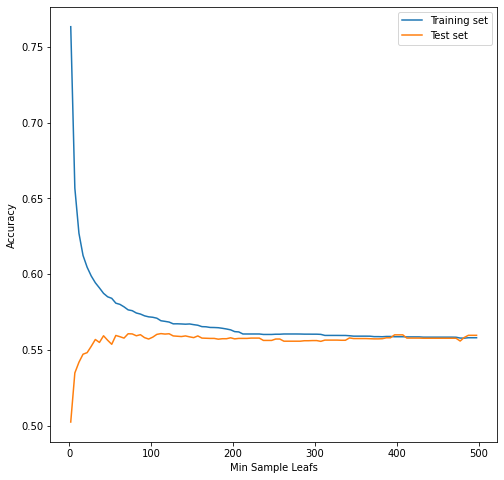

In [ ]:
import matplotlib.pyplot as plt
test_score = []
train_score = []
min_sample_split = np.arange(2, 500, 5)

for samples_split in min_sample_split:
  dtree = DecisionTreeClassifier(min_samples_leaf=samples_split)
  dtree.fit(X_train, y_train)
  train_score.append(dtree.score(X_train,y_train))
  test_score.append(dtree.score(X_test,y_test))
  
plt.figure(figsize = (8,8))   
plt.plot(min_sample_split,train_score)
plt.plot(min_sample_split, test_score)
plt.xlabel('Min Sample Leafs')
plt.ylabel('Accuracy')
plt.legend(['Training set','Test set'])

This is similar to the previous parameter, but concerns the leaf nodes.  If this limit is too tight, our model would underfit.

### 5.Vary themax_depth hyperparameter:


#### a. Assign a limiting depth,e.g.4,for our hyper parameter and report thea ccuracy, precision, recall and F1score.
#### b. Assign a 2nd limiting depth,e.g.8,for our hyperparameter and report the accuracy, precision, recall and F1score


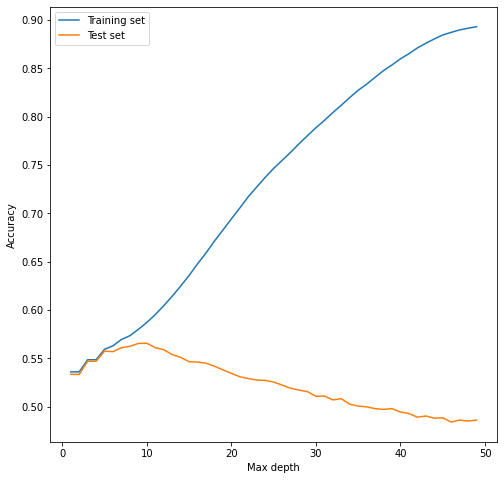

In [ ]:
max_depth_range = np.arange(1, 50, 1)
test_score = []
train_score = []

for max_depth in max_depth_range:
  dtree = DecisionTreeClassifier(max_depth=max_depth)
  dtree.fit(X_train, y_train)
  y_hat = dtree.predict(X_test)
  train_score.append(dtree.score(X_train,y_train))
  test_score.append(dtree.score(X_test,y_test))
  
plt.figure(figsize = (8,8))   
plt.plot(max_depth_range, train_score)
plt.plot(max_depth_range, test_score)
plt.xlabel('Max depth')
plt.ylabel('Accuracy')
plt.legend(['Training set','Test set'])

NOTE: The deeper the tree is, the better it fits the training data. If it is too deep though, it seems to fails to generalize and starts to overfit. More complex paths are created and the number of samples in every split is getting smaller and therefor less statistically meaningful.

### 6. Hyper parameter overview:
Providea 2–3 paragraph summary of the results of your hyper parameter exploration.How did your ML model improve or depreciate with these
variations? Note: It will be tempting to use something like gridsearch,but this automated approach will make it more diculttounderstandhowthesevariationsalteryourtree,so we recommend varying them manually.

Provided under each code cell.

### Final Decision Tree  & Evaluation


#### 1.Which feature was used for the first split?

In [ ]:
dtree = DecisionTreeClassifier(
    max_depth=11,
    min_samples_split=50
    )
dtree.fit(X_train, y_train)
y_hat = dtree.predict(X_test)

tree_path = list(zip(X_train.columns[dtree.tree_.feature], dtree.tree_.threshold, dtree.tree_.children_left, dtree.tree_.children_right))
print(tree_path[0])

print(classification_report(
          y_test, 
          y_hat,
          labels=np.array(labels)
        ))


('type_entire_home/apt', 0.5, 1, 364)
              precision    recall  f1-score   support

         <50       0.64      0.32      0.43      1365
      50-100       0.58      0.72      0.64      3397
     100-200       0.54      0.75      0.63      3342
     200-300       0.49      0.09      0.16       993
     300-400       0.58      0.02      0.04       335
     400-500       0.00      0.00      0.00       133
     500-600       0.00      0.00      0.00        62
     600-700       0.57      0.10      0.17        40
     700-800       0.75      0.09      0.17        32
     800-900       0.00      0.00      0.00        10
    900-1000       0.00      0.00      0.00        16
     over 1k       0.29      0.08      0.12        52

    accuracy                           0.56      9777
   macro avg       0.37      0.18      0.20      9777
weighted avg       0.55      0.56      0.52      9777



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



#### 2.How many leaves are in the optimal classifier/ML model?


In [ ]:
print(dtree.tree_.n_leaves)

308


#### 3.Produce a confusion_matrix and describe your ML model’s accuracy interms of the number of true and false positives and negatives

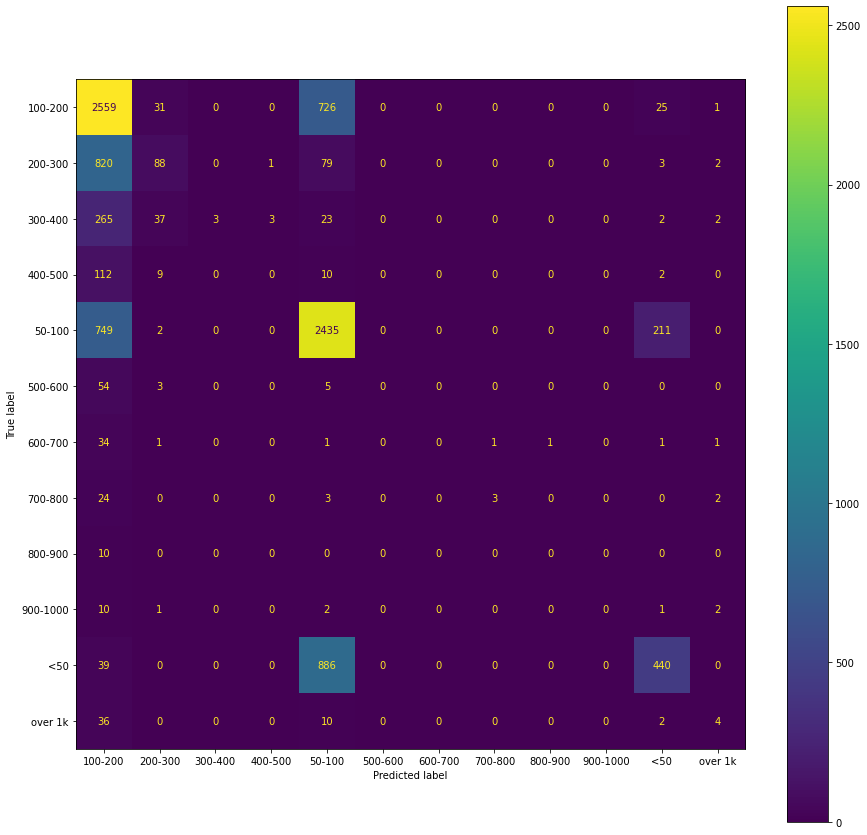

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

confusion_matrix = confusion_matrix(y_test, y_hat, labels=dtree.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix,
                              display_labels=dtree.classes_)

fig, ax = plt.subplots(figsize=(15,15))
disp.plot(ax=ax)

# calculating false positives
FP = confusion_matrix.sum(axis=0) - np.diag(confusion_matrix)  
# calculating false negatives
FN = confusion_matrix.sum(axis=1) - np.diag(confusion_matrix)
# calculating true positives
TP = np.diag(confusion_matrix)
# calculating true negatives
TN = confusion_matrix.sum() - (FP + FN + TP)


### 4.Usingscikit-learn’sclassification_report method,generatetheaccuracy,precision, recall, and F1score for your model and describe yourML model’s accuracy.

In [ ]:
print(classification_report(
          y_test, 
          y_hat,
          labels=np.array(labels)
        ))

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



              precision    recall  f1-score   support

         <50       0.64      0.32      0.43      1365
      50-100       0.58      0.72      0.64      3397
     100-200       0.54      0.77      0.64      3342
     200-300       0.51      0.09      0.15       993
     300-400       1.00      0.01      0.02       335
     400-500       0.00      0.00      0.00       133
     500-600       0.00      0.00      0.00        62
     600-700       0.00      0.00      0.00        40
     700-800       0.75      0.09      0.17        32
     800-900       0.00      0.00      0.00        10
    900-1000       0.00      0.00      0.00        16
     over 1k       0.29      0.08      0.12        52

    accuracy                           0.57      9777
   macro avg       0.36      0.17      0.18      9777
weighted avg       0.57      0.57      0.52      9777



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



## Visualize the structure of your final ML model:


### 5.Plot your tree. [Hint: using scikit-learn’stree.plot_tree]


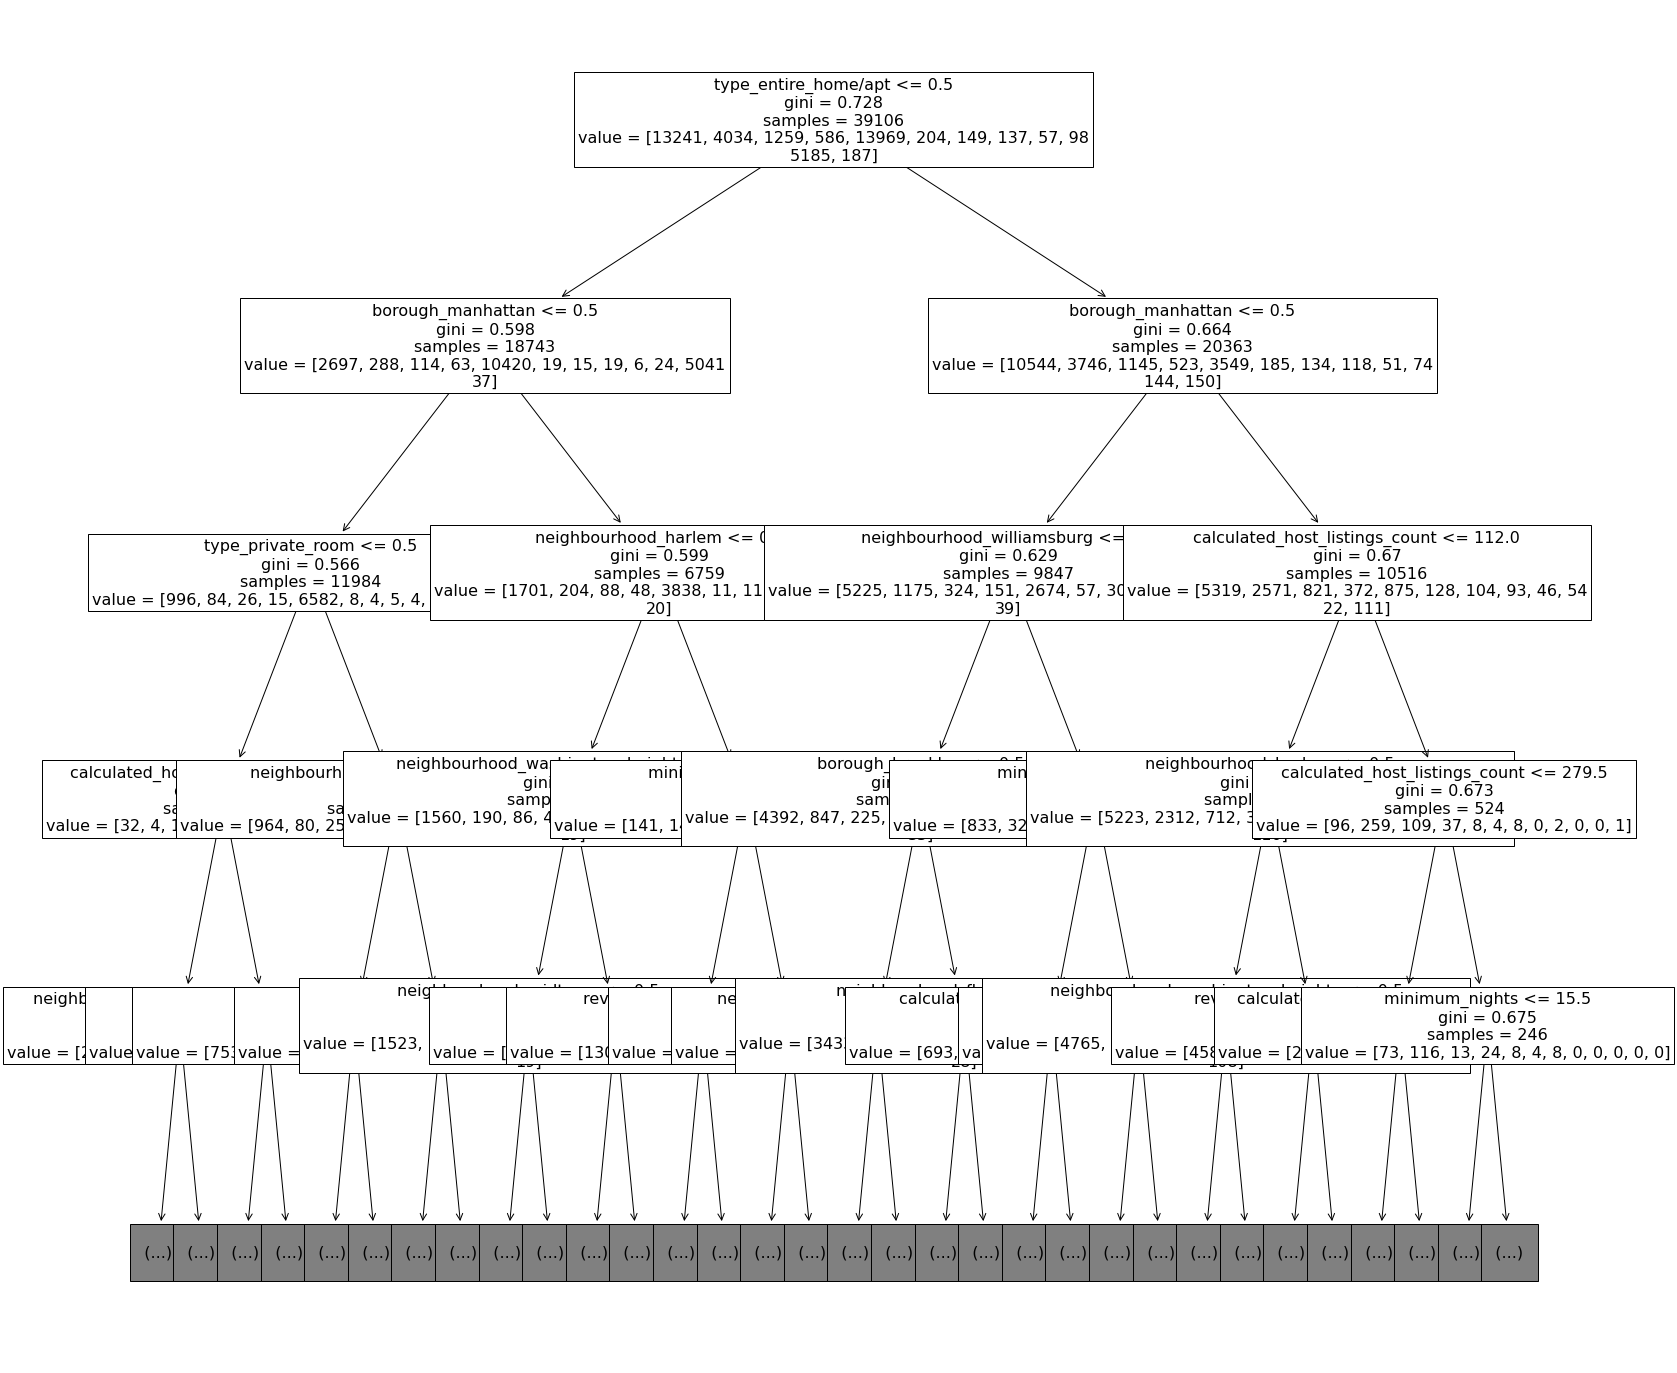

In [ ]:
from sklearn import tree

plt.figure(figsize=(25,25)) 
tree.plot_tree(dtree, max_depth = 4, fontsize = 16, feature_names=all_features)
plt.show()


### 6.Plot the decision surface of your tree using paired features.


[[ 0.8   0.82  0.84 ... 45.16 45.18 45.2 ]
 [ 0.8   0.82  0.84 ... 45.16 45.18 45.2 ]
 [ 0.8   0.82  0.84 ... 45.16 45.18 45.2 ]
 ...
 [ 0.8   0.82  0.84 ... 45.16 45.18 45.2 ]
 [ 0.8   0.82  0.84 ... 45.16 45.18 45.2 ]
 [ 0.8   0.82  0.84 ... 45.16 45.18 45.2 ]]


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning:

X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names



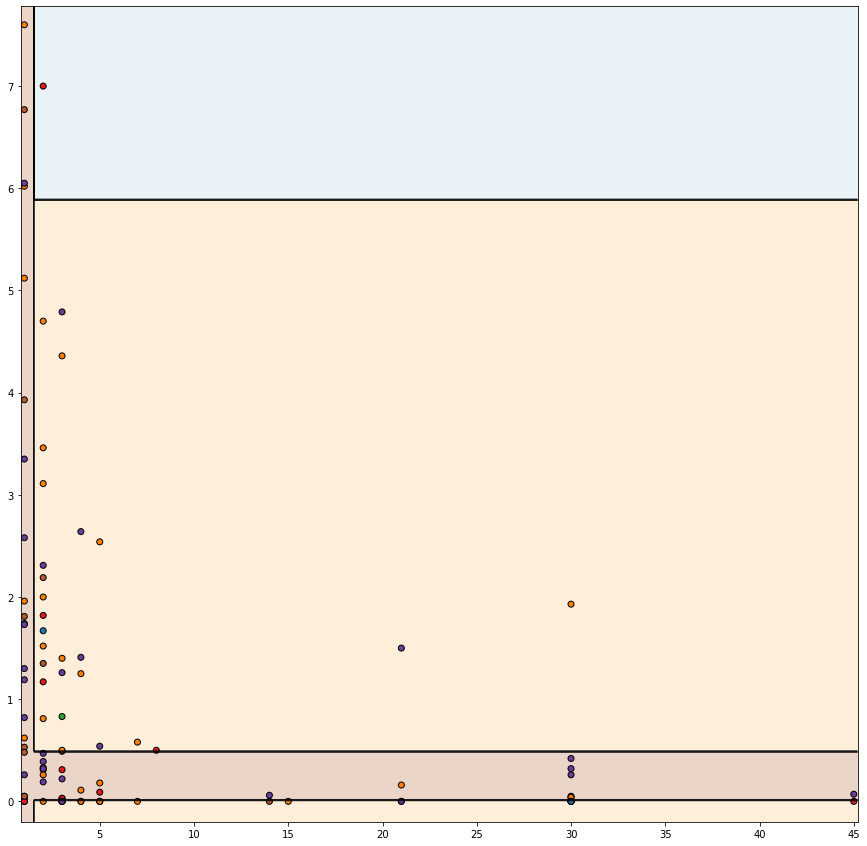

In [ ]:
def plot_decision_boundary(clf, X, Y, cmap='Paired_r'):
    h = 0.02
    x_min, x_max = X.iloc[:,0].min() - 10*h, X.iloc[:,0].max() + 10*h
    y_min, y_max = X.iloc[:,1].min() - 10*h, X.iloc[:,1].max() + 10*h
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    clf.fit(X, Y)
    
    print(xx)
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    plt.figure(figsize=(15,15))
    plt.contourf(xx, yy, Z, cmap=cmap, alpha=0.25)
    plt.contour(xx, yy, Z, colors='k', linewidths=0.7)
    plt.scatter(X.iloc[:,0], X.iloc[:,1], c=Y, cmap=cmap, edgecolors='k');


X_viz = X_train[['minimum_nights', 'reviews_per_month']].head(100) # session crashes with all datapoints
y_viz = y_train.head(100)


df_ = y_viz.to_frame()


df_['price_category'] = pd.Categorical(df_['price_category'])
df_['code'] = df_.price_category.cat.codes

y_viz=df_['code'].squeeze()


dtree_viz = DecisionTreeClassifier(
    max_depth=10,
    min_samples_split=50
    )



plot_decision_boundary(dtree_viz, X_viz, y_viz)

### Decision tree path:


#### 7. Provide a description of the potential path along your tree that a given new data point might take and provide its final result.The idea being that we want to know what decisions would be made along the way for that data point to end up at a particular label.

In [ ]:
n_nodes = dtree.tree_.node_count
children_left = dtree.tree_.children_left
children_right = dtree.tree_.children_right
feature = dtree.tree_.feature
threshold = dtree.tree_.threshold

node_depth = np.zeros(shape=n_nodes, dtype=np.int64)
is_leaves = np.zeros(shape=n_nodes, dtype=bool)

node_indicator = dtree.decision_path(X_test)
leaf_id = dtree.apply(X_test)

sample_id = 0
node_index = node_indicator.indices[
    node_indicator.indptr[sample_id] : node_indicator.indptr[sample_id + 1]
]

print(f"Rules used to predict sample {sample_id}:\n")
for node_id in node_index:
    # continue to the next node if it is a leaf node
    if leaf_id[sample_id] == node_id:
        continue
    # check if value of the split feature for sample 0 is below threshold
    if X_test.iat[sample_id, feature[node_id]] <= threshold[node_id]:
        threshold_sign = "<="
    else:
        threshold_sign = ">"
   
    print(
        f"decision node {node_id} : ({X_train.columns[feature[node_id]]} = {X_test.iat[sample_id, feature[node_id]]}) "
        f"{threshold_sign} {threshold[node_id]})"
    )
print(f"decision: {y_hat[sample_id]}")

Rules used to predict sample 0:

decision node 0 : (type_entire_home/apt = 0) <= 0.5)
decision node 1 : (borough_manhattan = 0) <= 0.5)
decision node 2 : (type_shared_room = 0) <= 0.5)
decision node 3 : (neighbourhood_williamsburg = 0) <= 0.5)
decision node 4 : (minimum_nights = 2) <= 5.5)
decision node 5 : (calculated_host_listings_count = 1) <= 16.0)
decision node 6 : (neighbourhood_long_island_city = 0) <= 0.5)
decision node 7 : (neighbourhood_greenpoint = 0) <= 0.5)
decision node 8 : (reviews_per_month = 0.09) > 0.004999999888241291)
decision node 12 : (borough_bronx = 0) <= 0.5)
decision: 50-100


That was the path for the first datapoint. Now, let's imagine we have an appartment in West Village (where Friends lived) to rent. This is our only rental and we just listed it, so no reviews. Minimum rent 1 night. Let's plot our tree in more readable form:

In [ ]:
from sklearn.tree import export_text

tree_rules = export_text(dtree, feature_names=list(X_train))

print(tree_rules)

|--- type_entire_home/apt <= 0.50
|   |--- borough_manhattan <= 0.50
|   |   |--- type_shared_room <= 0.50
|   |   |   |--- neighbourhood_williamsburg <= 0.50
|   |   |   |   |--- minimum_nights <= 5.50
|   |   |   |   |   |--- calculated_host_listings_count <= 16.00
|   |   |   |   |   |   |--- neighbourhood_long_island_city <= 0.50
|   |   |   |   |   |   |   |--- neighbourhood_greenpoint <= 0.50
|   |   |   |   |   |   |   |   |--- reviews_per_month <= 0.00
|   |   |   |   |   |   |   |   |   |--- neighbourhood_astoria <= 0.50
|   |   |   |   |   |   |   |   |   |   |--- class: 50-100
|   |   |   |   |   |   |   |   |   |--- neighbourhood_astoria >  0.50
|   |   |   |   |   |   |   |   |   |   |--- class: 50-100
|   |   |   |   |   |   |   |   |--- reviews_per_month >  0.00
|   |   |   |   |   |   |   |   |   |--- borough_bronx <= 0.50
|   |   |   |   |   |   |   |   |   |   |--- class: 50-100
|   |   |   |   |   |   |   |   |   |--- borough_bronx >  0.50
|   |   |   |   |   |   |  

Here is the path: 

(type_entire_home/apt = 1) <= 0.50 <br>
(borough_manhattan = 1) > 0.50 <br>
(calculated_host_listings_count = 1 ) <= 112.00 <br>
(neighbourhood_harlem = 0) <= 0.50 <br>
(neighbourhood_washington_heights = 0) <= 0.50 <br>
(reviews_per_month = 0) <= 0.00 <br>
(calculated_host_listings_count =1) <= 76.00 <br>
(minimum_nights =1) <= 7.50 <br>
(calculated_host_listings_count =1) <= 5.50 <br>
(neighbourhood_midtown = 0 )<= 0.50 <br>

class: 100-200

So we were asked 3 times about how many listings we have but were not asked about the West Village.


### ML model Accuracy
Perform a comparison of our decision tree model vs. k-NN model: provide a comparison table of accuracy for your various DT ML models and your k-NN ML models. This will be a tool for comparison for you as a technician, but it will also serve as a communication tool to summarize to stakeholders what you tried, what worked best, and why

              precision    recall  f1-score   support

         <50       0.58      0.36      0.45      1365
      50-100       0.58      0.69      0.63      3397
     100-200       0.55      0.73      0.63      3342
     200-300       0.40      0.17      0.24       993
     300-400       0.34      0.06      0.10       335
     400-500       0.20      0.01      0.01       133
     500-600       0.00      0.00      0.00        62
     600-700       0.60      0.15      0.24        40
     700-800       0.27      0.12      0.17        32
     800-900       0.00      0.00      0.00        10
    900-1000       0.00      0.00      0.00        16
     over 1k       0.00      0.00      0.00        52
    
    macro avg       0.29      0.19      0.21      9777
    weighted avg    0.53      0.56      0.53      9777
    accuracy                            0.56      9777



 


This was the k-NN's performance.
And here is the DT:

In [ ]:
print(classification_report(
          y_test, 
          y_hat,
          labels=np.array(labels)
        ))

              precision    recall  f1-score   support

         <50       0.64      0.32      0.43      1365
      50-100       0.58      0.72      0.64      3397
     100-200       0.54      0.75      0.63      3342
     200-300       0.49      0.09      0.16       993
     300-400       0.58      0.02      0.04       335
     400-500       0.00      0.00      0.00       133
     500-600       0.00      0.00      0.00        62
     600-700       0.57      0.10      0.17        40
     700-800       0.75      0.09      0.17        32
     800-900       0.00      0.00      0.00        10
    900-1000       0.00      0.00      0.00        16
     over 1k       0.29      0.08      0.12        52

    accuracy                           0.56      9777
   macro avg       0.37      0.18      0.20      9777
weighted avg       0.55      0.56      0.52      9777



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



We can see that the results are comparable. k-NN failed to classify all labels from 4 classes (500-600, 800-900, 900-1000, over 1000) just as DT model (but different classes): 400-500, 500-600, 600-700, 800-900, 900-1000. The only noticeable difference is macro average precision where DT beats k-NN .37 to .29 
Which is great if for our business objectives we valued the minority classes the most.

## Business Evaluation
One of the key objectives of this course is to learn how to implement ML algorithms to tackle business problems and objectives.Please provide us with a complete scenario of how the results of your decision tree classifier might be used.<br>
Note: you’ve previously considered some of these questions,the intent with reconsidering the mis to iterate on our problem after obtaining results from our ML model: <br><br>
**1.What might be the motivation for a decision tree classifier?<br>**
The most important motivation for using DT is its ability to utilise different feature subsets and decison rules at different stages of classification. Also, the understanding level of DT is very easy compared to other models.
<br><br>
**2.What is the “action” that should be taken given the results of this prediction?<br>**
With DTs, we need to start from the root of the tree and compare the values of the root attribute with the record's attribute. upn reaching the next node, we follow the branch corresponding to that value. Summary: 1. we need to begin the diagram with one main idea. 2) add decison nodes 3) expand to acquire end points 4) calculate tree values 5) evaluate the results
<br><br>
**3.Who is the best immediate person(s) to make use of the results of your prediction?<br>**
The model might help property owners to decide in which price range they could list the property.
<br><br>

**4.What is the potential payoff of this prediction for an organization? (e.g., costs or eciency).<br>**
Different stakeholders can make use of this model. For example, people who wish to invest in Airbnb can gain a relatively good understanding of the prices of various neighborhoods. They can then evaluate their profit using the prediction model, in combination with the property price and tax. In addition, the Airbnb company can include this feature on their website and provide a good estimate of the price of different locations, so that people can do Airbnb in NY more efficiently and can compare prices without spending too much time traveling to different locations.
<br><br>

**5.Do your ML models’ results change your problem? If so, how and why?  If not, please explain.<br>**
The results show that there are some ways to improve the accuaray, including using a comprehensive dataset with more relevenat data to predict the price more accuarately (we have good amount of data, but we need to have the type of data that have the most important impacts on price). Also, we may need to train the model using cross-validation to increase the efficiency of the model.
<br><br>